In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

sns.set_theme()

# Load Data

In [14]:
filename = "../data/all_data.json"
#filename = "csb-53/data/all_data.json"

df = pd.read_json(filename, convert_dates=["release_date"])
df.set_index("link_album")

# Limit number of metacritic only albums, to not unbalance the model
__df_metacritic = df.groupby([df["release_date"].dt.year]).apply(lambda grp: grp.nlargest(50, 'metascore'))

df_full = df[df["billboard"].notnull()
        | df["grammy"].notnull()
        | df["link_album"].isin(__df_metacritic["link_album"].unique())]
df = df_full[["artist", "album", "link_album", "genres"]]
df

,artist,album,link_album,genres
0,Sigur Rós,(),https://www.metacritic.com/music/()/sigur-ros,"[Indie, Rock]"
1,Ed Sheeran,Divide,https://www.metacritic.com/music/(divide)/ed-s...,[Pop/Rock]
2,Ed Sheeran,+,https://www.metacritic.com/music/+/ed-sheeran,[Pop/Rock]
3,Jewel,0304,https://www.metacritic.com/music/0304/jewel,"[Pop, Adult Alternative, Singer-Songwriter]"
6,Sia,1000 Forms of Fear,https://www.metacritic.com/music/1000-forms-of...,"[Electronic, Club/Dance]"
...,...,...,...,...
3240,Logic,YSIV,https://www.metacritic.com/music/ysiv/logic,"[Rap, Pop-Rap, Contemporary Rap]"
3241,Joanna Newsom,Ys,https://www.metacritic.com/music/ys/joanna-newsom,"[Indie, Rock, Folk]"
3242,Smashing Pumpkins,Zeitgeist,https://www.metacritic.com/music/zeitgeist/the...,"[Rock, Alternative]"
3244,Denzel Curry,ZUU,https://www.metacritic.com/music/zuu/denzel-curry,[Rap]


In [15]:
df_genres_clusters = pd.read_json("genres_clusters.json")
df_genres_clusters

,Pop/Rock,"Pop, R&B, Dance",Mainstream Rock,Rock Subgenres,Rap,Country
genres,[Pop/Rock],"[Pop, Electronic, Club/Dance, Dance-Pop, Conte...","[Indie, Rock, Singer-Songwriter, Alternative, ...","[Heavy Metal, Contemporary Pop/Rock, Adult Alt...","[Rap, Contemporary Rap, Hardcore Rap, Pop-Rap,...","[Country, Contemporary Country, Country-Pop]"
center,"[-0.3787931949, -0.39912255750000003, 0.0, 0.6...","[-0.2659918806, -0.1329176117, 0.5233144642, 0...","[0.46104715100000004, 1.4338092375, -0.3683138...","[-0.32223313870000003, -0.3143704366, 1.529492...","[-0.33423595910000004, -0.3621581815, 0.041575...","[-0.3339523274, -0.2847339303, 0.2426361358, -..."


In [16]:
dct_genres_cluster = dict(df_genres_clusters)
dct_reverse_genres = {}
for cluster, dct in df_genres_clusters.items():
    for genre in dct["genres"]:
        dct_reverse_genres[genre] = cluster
dct_reverse_genres

{'Pop/Rock': 'Pop/Rock',
 'Pop': 'Pop, R&B, Dance',
 'Electronic': 'Pop, R&B, Dance',
 'Club/Dance': 'Pop, R&B, Dance',
 'Dance-Pop': 'Pop, R&B, Dance',
 'Contemporary R&B': 'Pop, R&B, Dance',
 'R&B': 'Pop, R&B, Dance',
 'Soul': 'Pop, R&B, Dance',
 'Indie': 'Mainstream Rock',
 'Rock': 'Mainstream Rock',
 'Singer-Songwriter': 'Mainstream Rock',
 'Alternative': 'Mainstream Rock',
 'Metal': 'Mainstream Rock',
 'Dance': 'Mainstream Rock',
 'Heavy Metal': 'Rock Subgenres',
 'Contemporary Pop/Rock': 'Rock Subgenres',
 'Adult Alternative Pop/Rock': 'Rock Subgenres',
 'Alternative/Indie Rock': 'Rock Subgenres',
 'Indie Rock': 'Rock Subgenres',
 'Alternative Singer/Songwriter': 'Rock Subgenres',
 'Alternative Pop/Rock': 'Rock Subgenres',
 'Folk': 'Rock Subgenres',
 'Rap': 'Rap',
 'Contemporary Rap': 'Rap',
 'Hardcore Rap': 'Rap',
 'Pop-Rap': 'Rap',
 'Southern Rap': 'Rap',
 'Country': 'Country',
 'Contemporary Country': 'Country',
 'Country-Pop': 'Country'}

# Unwrap genres from DF

In [17]:
genres_allowed = list(dct_reverse_genres.keys())
# Remove pop rock because it is an outlier
genres_allowed.remove("Pop/Rock")

data = [[row[1], row[2], row[3], 
         genre, 
         dct_reverse_genres[genre]]
        for row in df.itertuples() for genre in (row[4] or []) if genre in genres_allowed]

df_unwrapped = pd.DataFrame.from_records(data, columns=list(df.columns) + ["cluster"])
df_unwrapped.rename(columns={"genres": "genre"}, inplace=True)
df_unwrapped

,artist,album,link_album,genre,cluster
0,Sigur Rós,(),https://www.metacritic.com/music/()/sigur-ros,Indie,Mainstream Rock
1,Sigur Rós,(),https://www.metacritic.com/music/()/sigur-ros,Rock,Mainstream Rock
2,Jewel,0304,https://www.metacritic.com/music/0304/jewel,Pop,"Pop, R&B, Dance"
3,Jewel,0304,https://www.metacritic.com/music/0304/jewel,Singer-Songwriter,Mainstream Rock
4,Sia,1000 Forms of Fear,https://www.metacritic.com/music/1000-forms-of...,Electronic,"Pop, R&B, Dance"
...,...,...,...,...,...
3669,Smashing Pumpkins,Zeitgeist,https://www.metacritic.com/music/zeitgeist/the...,Rock,Mainstream Rock
3670,Smashing Pumpkins,Zeitgeist,https://www.metacritic.com/music/zeitgeist/the...,Alternative,Mainstream Rock
3671,Denzel Curry,ZUU,https://www.metacritic.com/music/zuu/denzel-curry,Rap,Rap
3672,My Morning Jacket,Z,https://www.metacritic.com/music/z/my-morning-...,Indie,Mainstream Rock


In [18]:
df_genres_grammy = df_unwrapped[df_unwrapped.link_album.isin(df_full[df_full.grammy.notnull()].link_album)]
df_genres_grammy

,artist,album,link_album,genre,cluster
35,Adele,21,https://www.metacritic.com/music/21/adele,R&B,"Pop, R&B, Dance"
36,Adele,21,https://www.metacritic.com/music/21/adele,Soul,"Pop, R&B, Dance"
37,Adele,21,https://www.metacritic.com/music/21/adele,Adult Alternative Pop/Rock,Rock Subgenres
38,Adele,21,https://www.metacritic.com/music/21/adele,Alternative/Indie Rock,Rock Subgenres
44,Bruno Mars,24K Magic,https://www.metacritic.com/music/24k-magic/bru...,Pop,"Pop, R&B, Dance"
...,...,...,...,...,...
3626,Ed Sheeran,X,https://www.metacritic.com/music/x/ed-sheeran,Alternative/Indie Rock,Rock Subgenres
3627,Ed Sheeran,X,https://www.metacritic.com/music/x/ed-sheeran,Alternative Singer/Songwriter,Rock Subgenres
3630,Ne-Yo,Year Of The Gentleman,https://www.metacritic.com/music/year-of-the-g...,R&B,"Pop, R&B, Dance"
3631,Ne-Yo,Year Of The Gentleman,https://www.metacritic.com/music/year-of-the-g...,Soul,"Pop, R&B, Dance"


In [19]:
df_genres_billboard = df_unwrapped[df_unwrapped.link_album.isin(df_full[df_full.billboard.notnull()].link_album)]
df_genres_billboard

,artist,album,link_album,genre,cluster
2,Jewel,0304,https://www.metacritic.com/music/0304/jewel,Pop,"Pop, R&B, Dance"
3,Jewel,0304,https://www.metacritic.com/music/0304/jewel,Singer-Songwriter,Mainstream Rock
4,Sia,1000 Forms of Fear,https://www.metacritic.com/music/1000-forms-of...,Electronic,"Pop, R&B, Dance"
5,Sia,1000 Forms of Fear,https://www.metacritic.com/music/1000-forms-of...,Club/Dance,"Pop, R&B, Dance"
6,Tool,"10,000 Days",https://www.metacritic.com/music/10000-days/tool,Rock,Mainstream Rock
...,...,...,...,...,...
3663,Logic,YSIV,https://www.metacritic.com/music/ysiv/logic,Rap,Rap
3664,Logic,YSIV,https://www.metacritic.com/music/ysiv/logic,Pop-Rap,Rap
3665,Logic,YSIV,https://www.metacritic.com/music/ysiv/logic,Contemporary Rap,Rap
3669,Smashing Pumpkins,Zeitgeist,https://www.metacritic.com/music/zeitgeist/the...,Rock,Mainstream Rock


In [20]:
df_genres_metacritic = df_unwrapped[df_unwrapped.link_album.isin(__df_metacritic.link_album)]
df_genres_metacritic

,artist,album,link_album,genre,cluster
0,Sigur Rós,(),https://www.metacritic.com/music/()/sigur-ros,Indie,Mainstream Rock
1,Sigur Rós,(),https://www.metacritic.com/music/()/sigur-ros,Rock,Mainstream Rock
17,Blueprint,1988,https://www.metacritic.com/music/1988/blueprint,Indie,Mainstream Rock
18,Blueprint,1988,https://www.metacritic.com/music/1988/blueprint,Rap,Rap
19,Azealia Banks,1991 [EP],https://www.metacritic.com/music/1991-ep/azeal...,Rap,Rap
...,...,...,...,...,...
3667,Joanna Newsom,Ys,https://www.metacritic.com/music/ys/joanna-newsom,Rock,Mainstream Rock
3668,Joanna Newsom,Ys,https://www.metacritic.com/music/ys/joanna-newsom,Folk,Rock Subgenres
3671,Denzel Curry,ZUU,https://www.metacritic.com/music/zuu/denzel-curry,Rap,Rap
3672,My Morning Jacket,Z,https://www.metacritic.com/music/z/my-morning-...,Indie,Mainstream Rock


# Entropy (raw genres)

Entropies (higher, the more random):
Grammy: 2.6934134274879207
Billboard: 2.878753080437296
Metacritic: 2.630673316411496


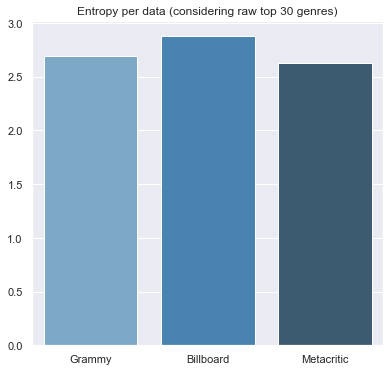

In [21]:
entropy = scipy.stats.entropy
grammy_entropy = entropy(df_genres_grammy["genre"].value_counts())
billboard_entropy = entropy(df_genres_billboard["genre"].value_counts())
metacritic_entropy = entropy(df_genres_metacritic["genre"].value_counts())

print("Entropies (higher, the more random):")
print("Grammy:", grammy_entropy)
print("Billboard:", billboard_entropy)
print("Metacritic:", metacritic_entropy)

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.tight_layout(pad=2.0)
fig.set_figheight(6)
fig.set_figwidth(6)

sns.barplot(x=["Grammy", "Billboard", "Metacritic"], 
            y=[grammy_entropy, billboard_entropy, metacritic_entropy], 
            palette="Blues_d", ax=axes)

axes.set_title("Entropy per data (considering raw top 30 genres)")
# axes.set_ybound(2.5, 3)

plt.show(fig)

Billboard has the highest entropy and Metacritic the lowest, althought they are all very similar. 

This means that actually Metacritic is the one with less variety in albuns.

# Entropy (genres clusters)

Entropies (higher, the more random):
Grammy: 1.5087788626237324
Billboard: 1.5409623656000178
Metacritic: 1.3256525924096658


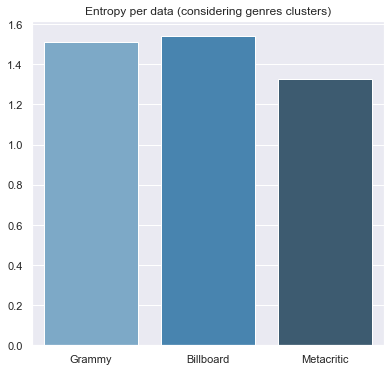

In [22]:
entropy = scipy.stats.entropy
grammy_entropy = entropy(df_genres_grammy["cluster"].value_counts())
billboard_entropy = entropy(df_genres_billboard["cluster"].value_counts())
metacritic_entropy = entropy(df_genres_metacritic["cluster"].value_counts())

print("Entropies (higher, the more random):")
print("Grammy:", grammy_entropy)
print("Billboard:", billboard_entropy)
print("Metacritic:", metacritic_entropy)

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.tight_layout(pad=2.0)
fig.set_figheight(6)
fig.set_figwidth(6)

sns.barplot(x=["Grammy", "Billboard", "Metacritic"], 
            y=[grammy_entropy, billboard_entropy, metacritic_entropy], 
            palette="Blues_d", ax=axes)

axes.set_title("Entropy per data (considering genres clusters)")
# axes.set_ybound(2.5, 3)

plt.show(fig)

Well, the result is even worse for metacritic